<H1>Authorship in the Federalist Papers</H1>
Use this notebook to replicate the results reporter in the paper  </br>
<ul>
    [1] <a href = https://arxiv.org/abs/1911.01208>
    Kipnis, A., ``Higher Criticism for Discriminating Word-Frequency Tables and Testing Authorship'', 2019
    </a>
</ul>

Use an HC-based test to provide out-of-the-box solution to the case studied in
<ul>
    [2] Mosteller, Frederick, and David L. Wallace. ``<em>Inference in an authorship problem: A comparative study of discrimination methods applied to the authorship of the disputed Federalist Papers</em>''. Journal of the American Statistical Association 58, no. 302 (1963): 275-309.
 </ul>
</br>


In [14]:
import pandas as pd
import numpy as np

#import auxiliary functions for python
import sys
sys.path.append('../')
from AuthAttLib.AuthAttLib import *
from AuthAttLib.FreqTable import *
from AuthAttLib.visualize_HC_scores import *
from AuthAttLib.utils import *
import plotnine
from plotnine import *

<H2>Load Data</H2>

In [5]:
print("loading first 77 Federalists Papers:")
from LoadFederalistPapers import load_Federalists_Papers
fed_papers = load_Federalists_Papers(path = "./Federalist_Papers.txt")

# arrange data in the format accepted by AuthAttribLib.AuthorshipAttributionMulti:
# pandas DataFrame with columns 'doc_id', 'author', 'text'
fed_papers.loc[:,'doc_id'] = fed_papers.paper_no


loading first 77 Federalists Papers:
Documents loaded:
	 43 Hamilton papers
	 14 Madison papers
	 12 disputed papers


### Build vocabulary

In [8]:
#1500 most frequent words by each author, unionized
punct = ['!','?',':',';','"','(',')','-',',','.','`','\`','``','\'\'']
vocab = n_most_frequent_words_per_author(
    fed_papers[fed_papers.author.isin(['Hamilton','Madison'])],
    n = 1500, 
    words_to_ignore=punct) 
print(f"Vocab size = {len(vocab)}")

Vocab size = 1995


<H2>Train Model</H2>

In [121]:
data_train = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]

#build model
model = AuthorshipAttributionMulti(data_train,
                                   min_cnt=0,
                                   vocab=vocab,
                                   gamma=0.25)

## Asses performance using leave-one-out HC scores

In [122]:
df = model.compute_inter_similarity(LOO = True, wrt_authors=['Hamilton', 'Madison'])

/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 8 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: HC_Hamilton_vs_Madison.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


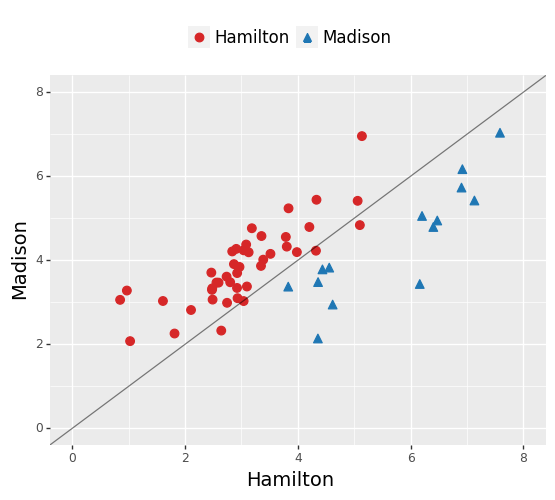

<ggplot: (348768522)>


In [123]:
# illustrate HC scores 
path_to_plots = ""

plotnine.options.figure_size = (6.4, 4.8)
p = (plot_author_pair(df, value = 'HC') + 
     theme(legend_title = element_blank(), legend_position = "top",
            plot_title = element_text(hjust = 0.5, size=16), 
            legend_text=element_text(size=12),
            axis_title_x = element_text(size = 14),
            axis_title_y = element_text(size = 14))
    ) + xlim(0,8) + ylim(0,8)

p.save(path_to_plots + 'HC_Hamilton_vs_Madison.png', height = 8 , width = 8)
print(p)


## Evaluate HC-Discrepancies of the Disputed Papers 

100%|██████████| 2/2 [00:00<00:00,  2.41it/s]
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 8 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: HC_Hamilton_vs_Madison_all.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


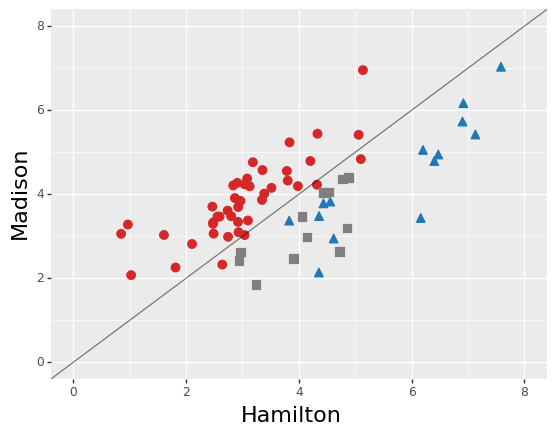

<ggplot: (349580804)>


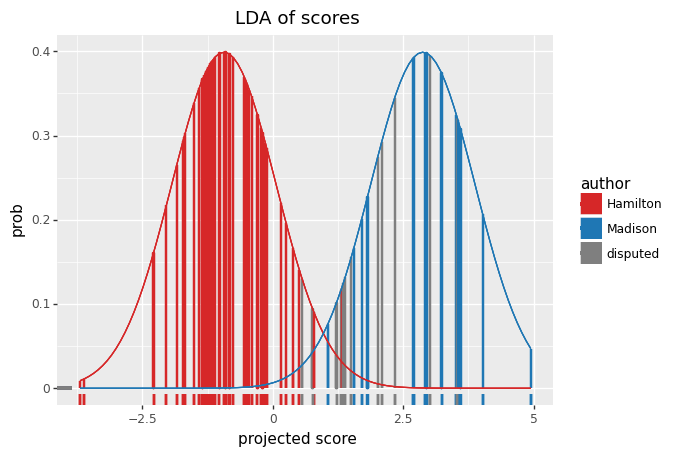

<ggplot: (349981579)>


In [124]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_disputed = model.stats_list(data_disputed, LOO = True)  

# illustrate HC scores

df_all = pd.concat([df, df_disputed], sort = True)

p = (plot_author_pair(df_all, value = 'HC', wrt_authors=['Hamilton','Madison']) + theme(legend_title = element_blank(), legend_position = "none",
            plot_title = element_text(hjust = 0.5, size=16), 
            legend_text= element_text(size=14),
            axis_title_x = element_text(size = 16),
            axis_title_y = element_text(size = 16))
      + xlim(0,8) + ylim(0,8) )
p.save(path_to_plots + 'HC_Hamilton_vs_Madison_all.png', height = 8 , width = 8)
print(p 
     )

p = plot_LDA(df_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            ) 
print(p + ggtitle("LDA of scores"))


<H2>P-values in rank-based test</H2>

In [94]:
def plot_author_pair_col(df, value, wrt_authors, test_author):
    df1 = df.filter(['doc_id', 'author', 'wrt_author', value])\
            .pivot_table(index = ['doc_id','author'],
                         columns = 'wrt_author',
                         values = [value])[value].reset_index()

    
    df1.loc[:, 'x'] = df1.loc[:, wrt_authors[0]].astype('float')
    df1.loc[:, 'y'] = df1.loc[:, wrt_authors[1]].astype('float')

    
    df2 = df1.melt(['author', 'doc_id'], ['x', 'y'],
                   var_name='wrt_author')
    df2.wrt_author = df2.wrt_author.str.replace('x',
                                                wrt_authors[0]).replace(
                                                    'y', wrt_authors[1])
    df2.doc_id = df2.doc_id.astype(int).astype(str)

    p = (ggplot(aes(x='doc_id', y='value', fill='wrt_author'),
                data=df2[df2.author == test_author]) +
         geom_bar(position='dodge', stat="identity", show_legend=False, width=.5) +
         xlab('Document ID') + ylab(value) +
         scale_fill_manual(values=LIST_OF_COLORS) +
         theme(legend_title=element_blank(), legend_position='top'))
    #ggtitle('Rank wrt each author ' + labels[0] + ' vs '+ labels[1])
    return p


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 8 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: pvals_wrt_author_bar.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


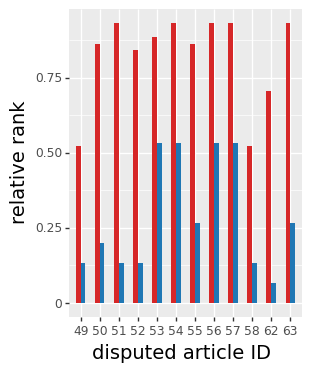

<ggplot: (349670135)>


In [131]:
# P-values in rank-based test:

plotnine.options.figure_size = (3, 4) #height = 8, width = 5
df_all.loc[:,'pval'] = 1-df_all.loc[:,'HC_rank']

df_all['rel_rank'] = 1 - df_all['pval']
p = plot_author_pair_col(df_all, value = 'rel_rank', 
                         wrt_authors = ('Hamilton', 'Madison'),
                         test_author='disputed') +\
theme(axis_title_x = element_text(size = 14),
      axis_title_y = element_text(size = 14),
      legend_text = element_text(size=12),
     ) + ylab('relative rank') + xlab('disputed article ID')

p.save(path_to_plots + 'pvals_wrt_author_bar.png', height = 8 , width = 4)
print(p)


<H2>Discriminiating Words</H2>

/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: discriminating_words_Federalists_1500w_0.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


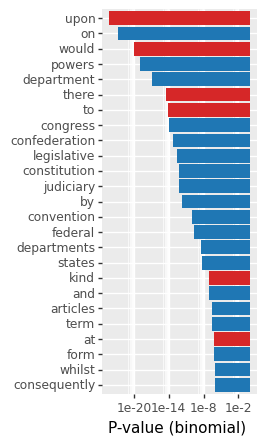

<ggplot: (349672768)>


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: discriminating_words_Federalists_1500w_1.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


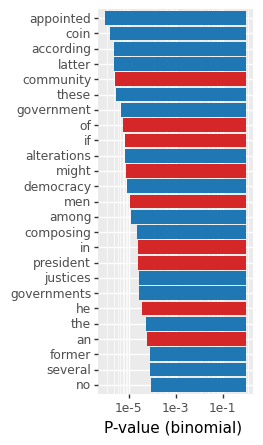

<ggplot: (349234189)>


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: discriminating_words_Federalists_1500w_2.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


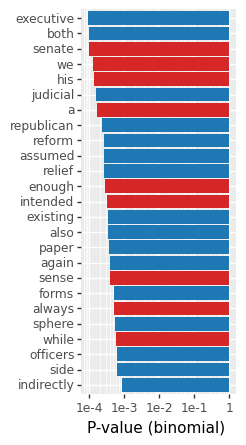

<ggplot: (349313410)>


In [72]:
# word discriminating between the two corpora:
df1 = model.two_author_test('Hamilton','Madison')
df1 =df1.sort_values('pval')

df_discriminating = df1[~np.isnan(df1.sign)]
plotnine.options.figure_size = (2, 5)

for i in [0,1,2] :
    k = 25
    p = (plot_col(df_discriminating.rename(columns={'feature' : 'term'})[i*k:k*(i+1)],
                 value='pval',sign='sign',wrt_authors=('Hamilton','Madison'),
                ) + ylab('P-value (binomial)')
                + theme(legend_position="none",
                )  
        )
    p.save(path_to_plots + f'discriminating_words_Federalists_1500w_{i}.png', height = 5 , width = 2)
    print(p)

<H1> Using ``non-contextual'' words from [1]</H1>

In [39]:
MW_final = ["upon", "also" ,"an", "by" , "of", "on", "there", "this", "to", "although", "both", "enough", 
    "while", "whilst", "always", "though", "commonly", "consequently", "considerable",
    "according", "apt", "direction", "innovation", "language", "vigor", "kind",
    "matter", "particularly", "probability", "work"]

function_words =  ['a','as','do','has','is','no','or','than','this','when',
  'all','at','down','have','it','not','our','that','to','which',
  'also','be','even','her','its','now','shall','the','up','who',
  'an','been','every','his','may','of','should','their','upon','will',
  'and','but','for','if','more','on','so','then','was','with',
  'any','by','from','in','must','one','some','there','were','would',
  'are','can','had','into','my','only','such','thing','what','your']

# two list of additional words used by Mosteller & Wallace
additional_words1 = ['affect','city','direction','innovation','perhaps','vigor',
                    'again','commonly','disgracing','join','rapid','violate','although',
                    'consequently','either','language','sarne','violence','among','considerable',
                    'enough','most','second','voice','another','contribute','nor','still',
                    'where','because','defensive','fortune','offensive','those','whether',
                    'between','destruction','function','often','throughout', 'while','both',
                    'did','himself','pass','under','whilst']

additional_words2 = ['about','choice','proper','according','common','kind','propriety','adversaries',
                    'danger','large','provision','after','decide','decides','decided','deciding',
                    'likely','requiisite','aid','degree','matters','matter','substance','always',
                    'during','moreover','they','apt','expence','expences','necessary','though',
                    'asserted','expenses','expense','necessity','necessities','truth','truths',
                    'before','extent','others','us','being','follows','follow','particularly',
                    'usages','usage','better','I','principle','we','care','imagine','edit','editing',
                    'probability','work']

MW_vocab = function_words + additional_words1 + additional_words2


from text_processing import remove_parts_of_speach

def lemmatize_vocab(list_of_words) :
    return remove_parts_of_speach(" ".join(list_of_words), to_remove=[]).split()

# use 176 words considered in [1] :
vocab = lemmatize_vocab(MW_final)

In [40]:
train_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]
model_NC = AuthorshipAttributionMulti(train_data, 
                                      vocab = MW_vocab
                                     )

../AuthAttLib/AuthAttLib.py:362: DeprecationWarning: Use 'AuthorshipAttributionMulti.compute_inter_similarity' and 'AuthorshipAttributionMulti.get_inter_similarity' instead.
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by 

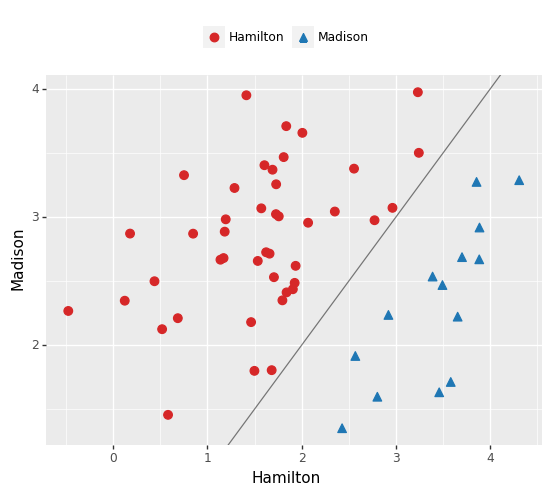

<ggplot: (354698762)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


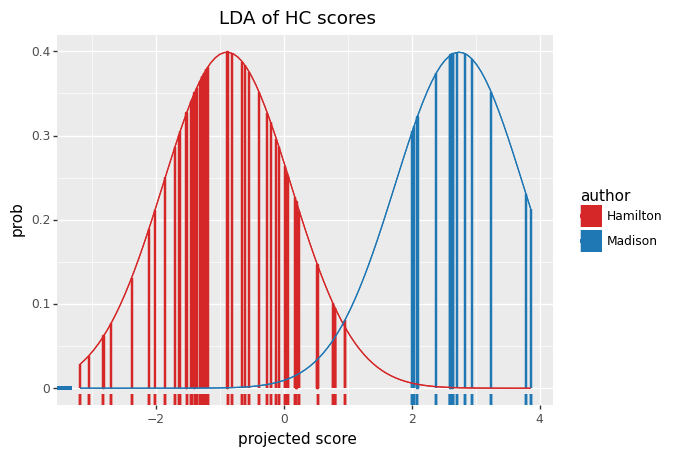

<ggplot: (354711381)>


In [41]:
# HC score of each document with respect to the rest in training set
df_NC = model_NC.internal_stats()

# illustrate HC scores 
p = plot_author_pair(df_NC, value = 'HC')
print(p)

p = plot_LDA(df_NC, value = 'HC', wrt_authors=('Hamilton','Madison'))
print( p + ggtitle('LDA of HC scores'))

In [117]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_NC_disputed = model_NC.stats_list(data_disputed, LOO = False)  

# illustrate HC scores

df_NC_all = pd.concat([df_NC, df_NC_disputed], sort = False)

p = plot_author_pair(df_NC_all, value = 'HC', wrt_authors=['Hamilton','Madison'])
print(p + ggtitle("HC scored wrt to each corpus"))

p = plot_LDA(df_NC_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            )
print(p + ggtitle("LDA of scores"))


# P-values in rank-based test:
df_NC_all.loc[:,'pval'] = 1-df_NC_all.loc[:,'HC_rank']

p = plot_author_pair_col(df_NC_all, value = 'pval', wrt_authors = ('Hamilton', 'Madison'), test_author='disputed') +\
theme(legend_title=element_blank(), legend_position='top') + ylab('p-value (rank test)') + xlab('disputed article ID')
print(p)


NameError: name 'model_NC' is not defined

# Illustrate Three Fequency Table

In [126]:
import plotnine

plotnine.options.figure_size = (3, 5)

all_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison', 'disputed'])]

#prepare model

model = AuthorshipAttributionMulti(all_data,
                                   min_cnt=0,
                                   vocab=vocab,
                                   gamma=0.2)

In [129]:
k = 60
k1 = 500
f1 = model._AuthorModel['Hamilton']._counts
f2 = model._AuthorModel['Madison']._counts

dtm = model._AuthorModel['disputed']._dtm
i = np.random.randint(dtm.shape[0])
f3 = np.asarray(dtm[i].todense())[0]
dfs = pd.DataFrame({'word' : vocab, 'Hamilton' : f1 / f1.sum(), 'Madison' : f2 / f2.sum(), 'disputed' : f3/f3.sum()})

dfs['total'] = dfs['Hamilton'] + dfs['Madison'] + dfs['disputed']
dfs = dfs.sort_values('total', ascending=False)\
       .head(k1)\
       .sample(n=k)\
       .sort_values('total', ascending=False)\
       .reset_index()\
       .drop(['index','total'], axis=1)
       
lo_words = dfs.word.tolist()[::-1]
dfs['word'] = pd.Categorical(dfs['word'], categories = lo_words)

/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: word_freq_table_exm_0.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in

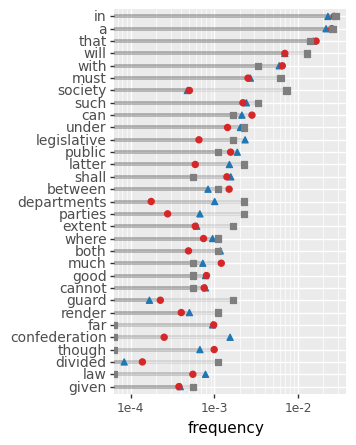

<ggplot: (349858663)>


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: word_freq_table_exm_1.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in

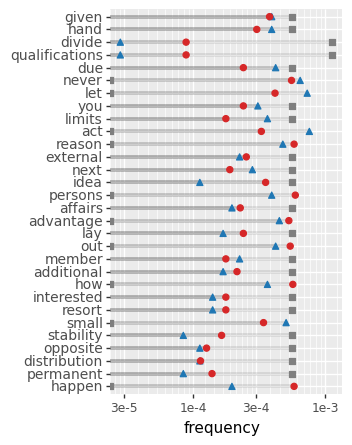

<ggplot: (349530375)>


In [130]:

#df1['f'] = -np.log10(df1['f'])
L = len(dfs) // 2

for i in [0, 1] :
    df1 = dfs.loc[i*L:(i+1)*L,:].melt(id_vars = 'word', var_name = 'author', value_name= 'f')
    p = (ggplot(aes(x = 'word', y = 'f', shape='author'), data=df1) + 
             #geom_bar(position='dodge', stat="identity", show_legend=False, size=.5) +
             geom_segment(aes(xend='word', y=0, yend='f', fill='word'), show_legend=False, alpha=.1, size=1.5) +
             geom_point(aes(color='author'), show_legend=False, size=2) +
             scale_color_manual(values = LIST_OF_COLORS) +
             coord_flip() + 
             scale_y_log10() +
             ylab('frequency') +
             xlab('') +
             theme(legend_position='top', legend_title=element_blank(),
                     legend_text=element_text(size=12),
                     axis_text_y=element_text(size=10)
                                )

            )
    p.save(f"word_freq_table_exm_{i}.png")
    print(p)